In [8]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.sandbox.stats.multicomp import multipletests
from collections import Counter
from tqdm import tqdm_notebook

red = '#FF3300'
blue = '#0099CC'
green = '#00CC66'

%matplotlib inline
sns.set(style='ticks', font_scale=1.7)

## Критерии согласия

### Критерий согласия Пирсона (хи-квадрат)

$\mathsf{H}_0\colon$ Выборка из некоторого класса распределений

$\mathsf{H}_1\colon\ \mathsf{H}_0$ не верна.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html#scipy.stats.chisquare">`chisquare`</a>`(f_obs, f_exp=None, ddof=0)`

* `f_obs` --- число элементов выборки, попавших в каждый из интервалов
* `f_exp` --- ожидаемое число (по умолчанию равномерное)
* `ddof` --- поправка на число степеней свободы. Статистика асимптотически будет иметь распределение $k - 1 - ddof$, где $k$ --- число интервалов.

In [9]:
sps.chisquare([16, 18, 16, 14, 12, 12])

Power_divergenceResult(statistic=2.0, pvalue=0.8491450360846096)

In [10]:
sps.chisquare([16, 18, 16, 14, 12, 12], f_exp=[16, 16, 16, 16, 20, 4])

Power_divergenceResult(statistic=19.7, pvalue=0.0014224993317060594)

In [11]:
sps.chisquare([16, 18, 16, 14, 12, 12], f_exp=[16, 16, 16, 16, 24, 0])

/home/havingfun/.local/lib/python3.8/site-packages/scipy/stats/stats.py:6125: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


Power_divergenceResult(statistic=inf, pvalue=0.0)

Эксперимент с группами крови

In [12]:
sps.chisquare([121, 120, 79, 33], f_exp=np.array([0.343, 0.340, 0.224, 0.093]) * 353, ddof=2)

Power_divergenceResult(statistic=0.001011144526478114, pvalue=0.9746327438096731)

Посмотрим, насколько хорошо выполняется асимптотика (теорема:
в условиях регулярности $\widehat{\chi} \stackrel{d_0}{\longrightarrow}  \chi^2_{k-1-d }$)


при справедливости нулевой гипотезы для разных распределений.

**1.** Равномерное на 5 элементах

In [15]:
sample_size = 1000
sample_count = 100000
chisq_values = np.zeros(sample_count)

for i in tqdm_notebook(range(sample_count)):
    sample = sps.randint(low=0, high=5).rvs(size=sample_size)
    f_obs = np.array(list(Counter(sample).values()))
    chisq_values[i] = sps.chisquare(f_obs)[0]

plt.figure(figsize=(10, 5))
grid = np.linspace(0, 15, 100)
plt.plot(grid, sps.chi2(df=4).pdf(grid), 
         lw=5, color=blue, label='Плотность')
plt.hist(chisq_values, bins=200, 
         color='orange', density=True, label='Приближение')
plt.title('Точность приближения в критерии хи-квадрат')
plt.legend();

<ipython-input-15-a2c66b48bb30>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(sample_count)):
Exception ignored in: <function tqdm.__del__ at 0x7f1b997af4c0>
Traceback (most recent call last):
  File "/home/havingfun/.local/lib/python3.8/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/home/havingfun/.local/lib/python3.8/site-packages/tqdm/notebook.py", line 275, in close
    self.disp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

**2.** Равномерное на 4 элементах, а 5-й с очень маленькой вероятностью.

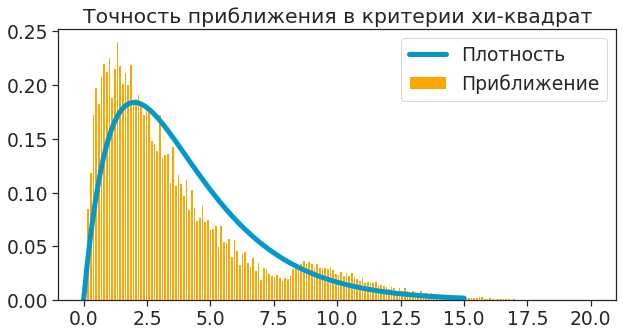

In [ ]:
chisq_values = np.zeros(sample_count)

epsilon = 0.0001
pk = np.array([0.25 - epsilon / 4] * 4 + [epsilon])
some_distribution = sps.rv_discrete(name='1', values=(np.arange(5), pk))

for i in tqdm_notebook(range(sample_count)):
    sample = some_distribution.rvs(size=sample_size)
    f_obs = np.array(list(Counter(sample).values()))
    if len(f_obs) == 4: f_obs = np.append(f_obs,[0])
    f_exp = pk * sample_size
    chisq_values[i] = sps.chisquare(f_obs, f_exp=f_exp)[0]

plt.figure(figsize=(10, 5))
grid = np.linspace(0, 15, 100)
plt.plot(grid, sps.chi2(df=4).pdf(grid), 
         lw=5, color=blue, label='Плотность')
plt.hist(chisq_values, bins=200, 
         color='orange', density=True, label='Приближение', range=(0, 21))
plt.title('Точность приближения в критерии хи-квадрат')
plt.xlim((-1, 21));
plt.legend();

**Вывод:** асимптотика ломается, если есть интервалы с малой вероятностью или с малым числом элементов в выборке.

### Критерий согласия Колмогорова (-Смирнова) {для нормальных Лиллиефорса}

$\mathsf{H}_0\colon$ Выборка из некоторого класса распределений

$\mathsf{H}_1\colon\ \mathsf{H}_0$ не верна.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest">`kstest`</a>`(rvs, cdf, args=())`

* `rvs` --- выборка
* `cdf` --- функция распределения (сама функция или ее название)
* `args` --- параметры распределения

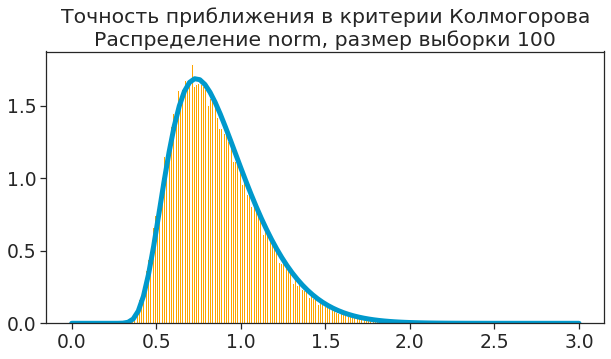

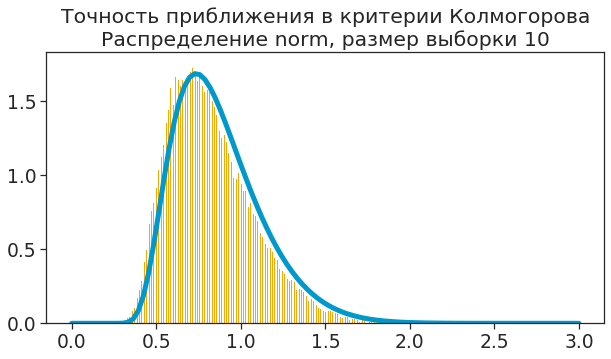

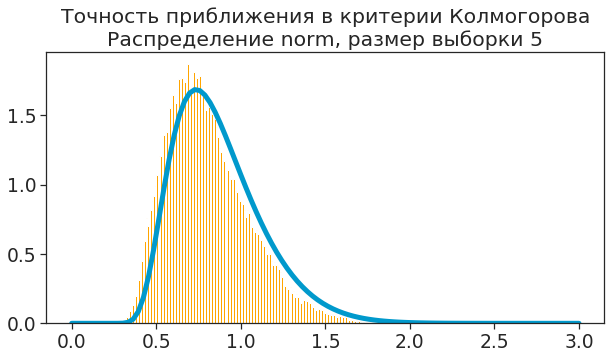

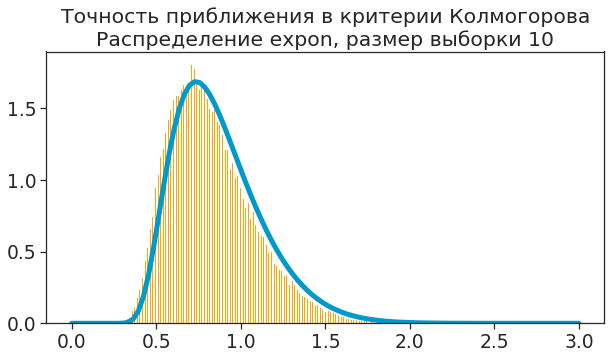

In [ ]:
grid = np.linspace(0, 3, 100)
n_iter = 100000

for size, distr in zip([100, 10, 5, 10], [sps.norm] * 3 + [sps.expon]):
    D = []
    
    samples = distr.rvs(size=(n_iter, size))
    for i in tqdm_notebook(range(n_iter), leave=False):
        D.append(sps.kstest(samples[i], cdf=distr.cdf)[0])

    plt.figure(figsize=(10, 5))
    plt.plot(grid, sps.kstwobign.pdf(grid), 
             lw=5, label='Kolmogorov pdf', color=blue)
    plt.hist(np.array(D) * np.sqrt(size), bins=200, density=True, 
             label='hist $\\sqrt{n} D_n$', color='orange')
    plt.title('Точность приближения в критерии Колмогорова\n' \
              + 'Распределение {}, размер выборки {}'.format(distr.name, size))
    plt.show()

Рассмотрим случай $\mathsf{H}_0\colon \mathcal{N}(0, 1)$ 

In [ ]:
sns.set(style='darkgrid', font_scale=1.7)

def apply_kstest(sample, cdf=sps.norm.cdf):
    print(sps.kstest(sample, sps.norm.cdf))

    ecdf = ECDF(sample)
    grid = np.linspace(-3, 3, 500)

    plt.figure(figsize=(8, 3.5))
    plt.plot(grid, ecdf(grid), color=red, label='ecdf', lw=3)
    plt.plot(grid, cdf(grid), color=blue, label='cdf', lw=3)
    plt.legend()
    plt.show()

Нулевая гипотеза верна:

KstestResult(statistic=0.08237600150211866, pvalue=0.4877223292527129)


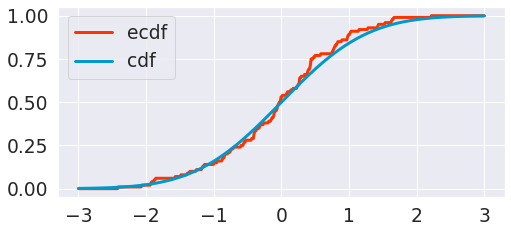

In [ ]:
apply_kstest(sps.norm.rvs(size=100))

Истинное распределение - Лапласс

KstestResult(statistic=0.10815556124535541, pvalue=0.17914691700639876)


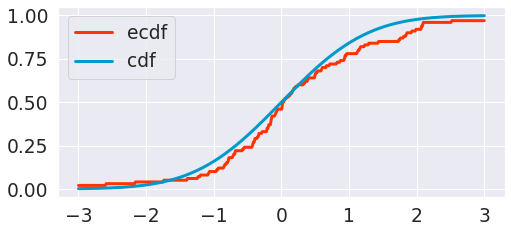

In [ ]:
apply_kstest(sps.laplace.rvs(size=100))

Истинное распределение - Коши

KstestResult(statistic=0.18756670386283075, pvalue=0.001489212227936959)


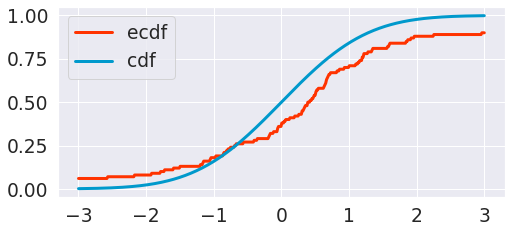

In [ ]:
apply_kstest(sps.cauchy.rvs(size=100))

KstestResult(statistic=0.10255129072305458, pvalue=0.2278742984580734)


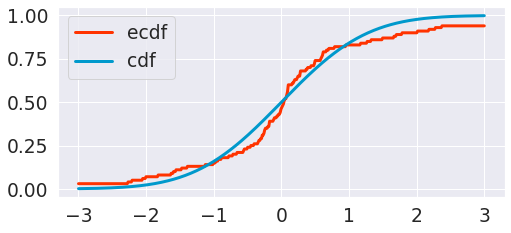

In [ ]:
apply_kstest(sps.cauchy(scale=0.5).rvs(size=100))

Истинное распределение &mdash; нормальное, $\mathrm{H}_0:$ распределение Лапласса.

KstestResult(statistic=0.09056612392589924, pvalue=0.3652768891115752)


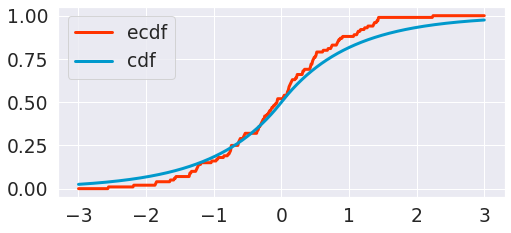

In [ ]:
apply_kstest(sps.norm.rvs(size=100), cdf=sps.laplace.cdf)

**Вывод:** Критерий не чувствителен к хвостам распределений.

### Критерий Андерсона-Дарлинга

$\mathsf{H}_0\colon$ Выборка из некоторого класса распределений

$\mathsf{H}_1\colon\ \mathsf{H}_0$ не верна.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html#scipy.stats.anderson">`anderson`</a>`(x, dist='norm')`

* `x` --- выборка
* `dist : {'norm', 'expon', 'logistic', 'gumbel'}` --- распределение

Возвращает `(statistic, critical_values, significance_level)`. В `critical_values` записаны пороги для критериев, которым соответствуют уровни значимости из `significance_level` в процентах. То есть критерий `{statistic > critical_values[i]}` имеет уровень значимости `significance_level[i]`.

In [ ]:
sample = sps.norm.rvs(size=100)
sps.anderson(sample)

AndersonResult(statistic=0.3551151814259441, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [ ]:
sample = sps.laplace.rvs(size=100)
sps.anderson(sample)

AndersonResult(statistic=2.1492631844960783, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [ ]:
sample = sps.cauchy.rvs(size=100)
sps.anderson(sample)

AndersonResult(statistic=30.650605026187066, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

### Q-Q plot

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html#scipy.stats.probplot">`probplot`</a>`(x, sparams=(), dist='norm', fit=True, plot=None)`

* `x` --- выборка
* `sparams` --- параметры распределения
* `dist` --- распределение
* `fit` --- подгонять ли линейную регрессию под точки
* `plot` --- рисовать на уже существующей фигуре

Возвращает:

* `(osm, osr)` --- теоретические и выборочные квантили
* `(slope, intercept, r)` --- не возвращается в случае `fit=False` и `plot=None`. Значения: коэффициенты линейной регрессии и метрика качества MSE (RSS). 


Сравниваем разные распределения с нормальным:

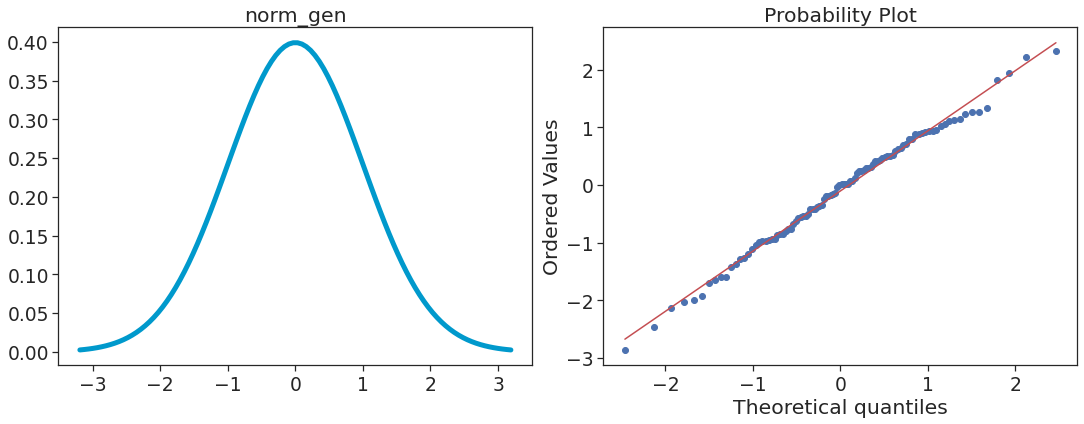

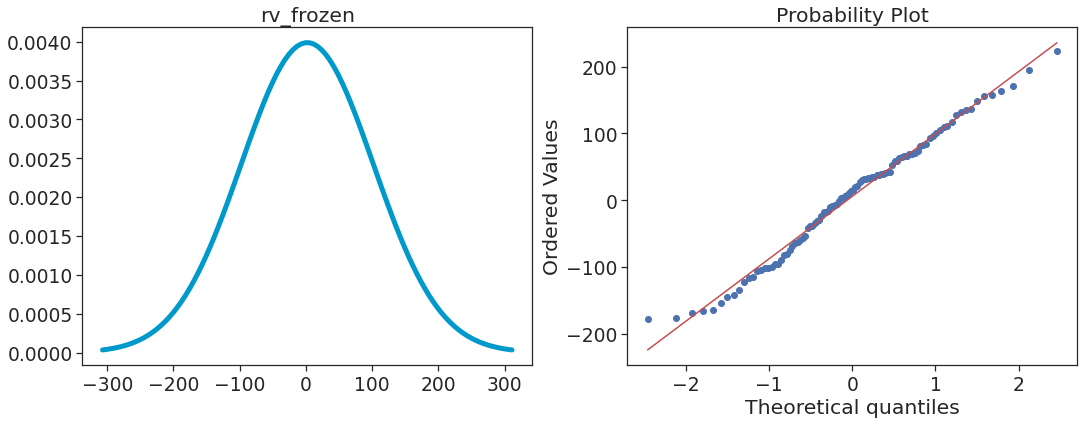

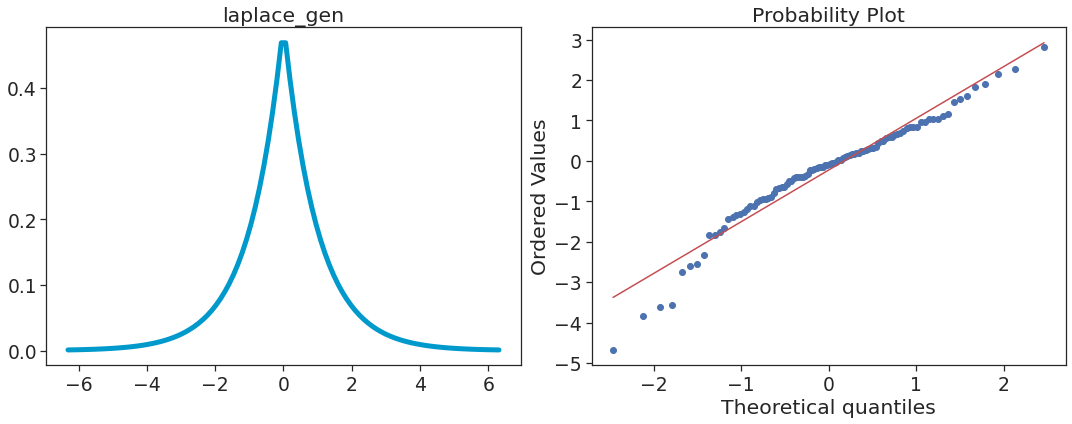

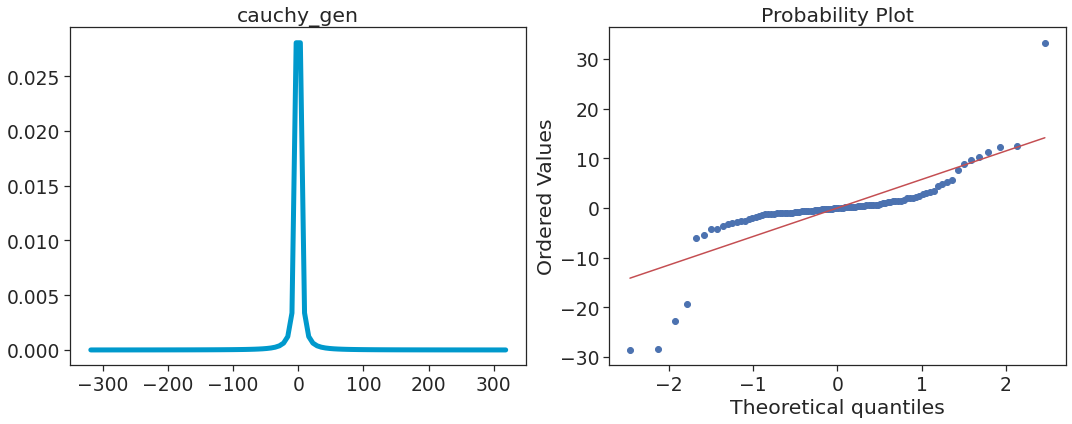

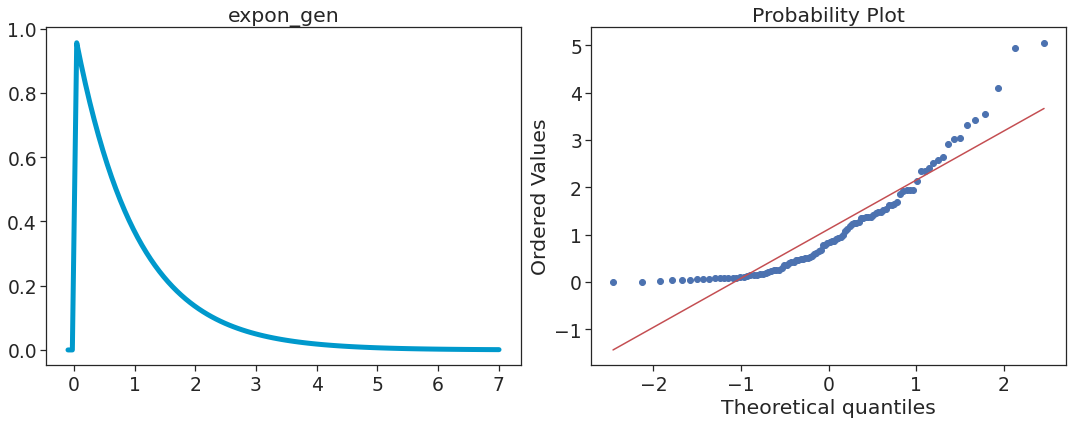

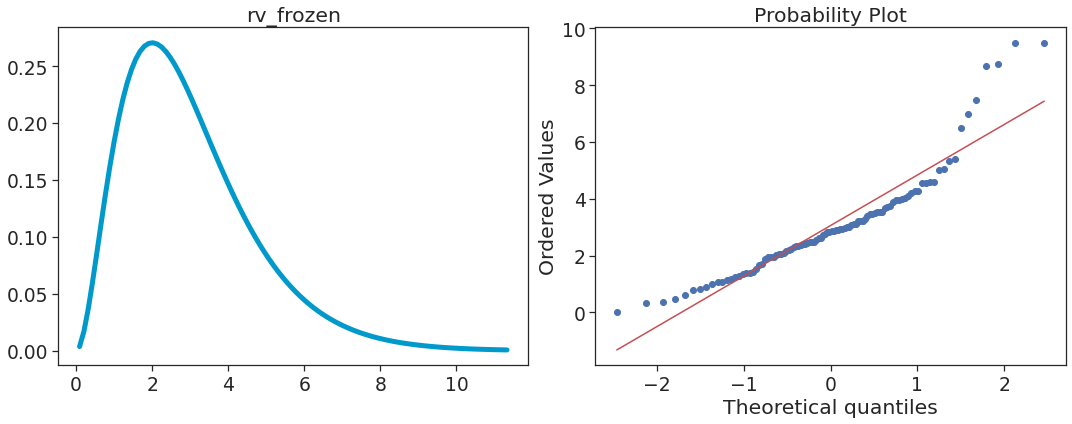

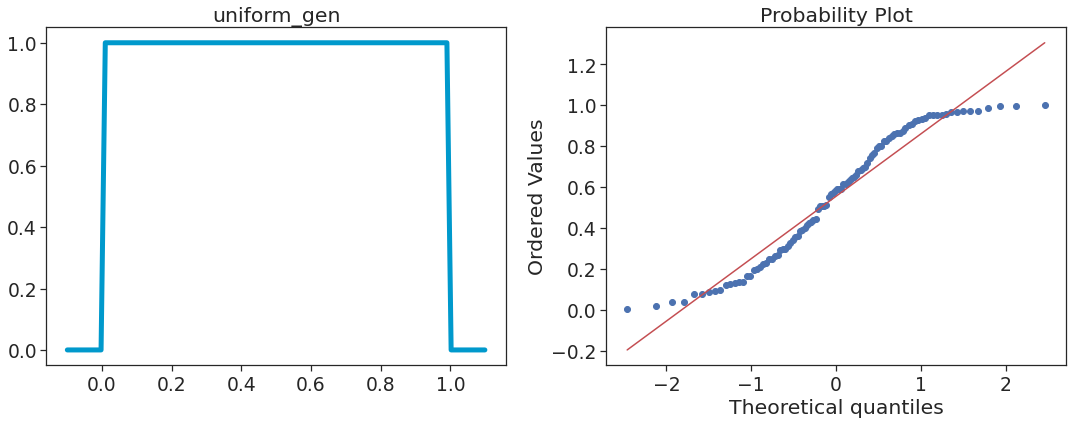

In [ ]:
for distr in [sps.norm, sps.norm(loc=2, scale=100), sps.laplace, sps.cauchy, 
              sps.expon, sps.gamma(a=3), sps.uniform]:
    sample = distr.rvs(size=100)

    plt.figure(figsize=(15, 6))

    ax = plt.subplot(1, 2, 1)
    grid = np.linspace(distr.ppf(0.001)-0.1, distr.ppf(0.999)+0.1, 100)
    plt.plot(grid, distr.pdf(grid), lw=5, color=blue)
    plt.title(str(distr).split(' ')[0].split('.')[-1])

    ax = plt.subplot(1, 2, 2)
    sps.probplot(sample, plot=ax)

    plt.tight_layout()
    plt.show()

### Критерий Шапиро-Уилка

$\mathsf{H}_0\colon$ Выборка из нормального распределения

$\mathsf{H}_1\colon\ \mathsf{H}_0\colon$ не верна.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html#scipy.stats.shapiro">`shapiro`</a>`(x): статистика W, p-value`

In [6]:
sps.shapiro(sps.norm.rvs(size=100))

(0.9916520714759827, 0.7954856753349304)

In [10]:
sps.shapiro(sps.norm(20, 100).rvs(size=100))

(0.992434561252594, 0.8517446517944336)

In [17]:
sps.shapiro(sps.laplace.rvs(size=100))

(0.9712493419647217, 0.027572009712457657)

In [19]:
sps.shapiro(sps.cauchy.rvs(size=100))

(0.7107640504837036, 9.67893083389515e-13)

### Критерий Жарка-Бера

$\mathsf{H}_0\colon$ Выборка из нормального распределения

$\mathsf{H}_1\colon\ \mathsf{H}_0$ не верна.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html#scipy.stats.jarque_bera">`jarque_bera`</a>`(x): jb_value, p-value`

In [25]:
sps.jarque_bera(sps.norm.rvs(size=100))

(0.9516473261310487, 0.6213730436049958)

In [27]:
sps.jarque_bera(sps.norm(20, 100).rvs(size=100))

(0.8985747258835903, 0.6380827110206726)

In [31]:
sps.jarque_bera(sps.laplace.rvs(size=100))

(39.58804004778699, 2.5325983532553664e-09)

In [28]:
sps.jarque_bera(sps.cauchy.rvs(size=100))

(839.7996107682308, 0.0)

## Пример: эксперимент Майкельсона

Данные классического эксперимента Майкельсона по измерению скорости света с помощью вращающегося зеркала, 100 наблюдений:

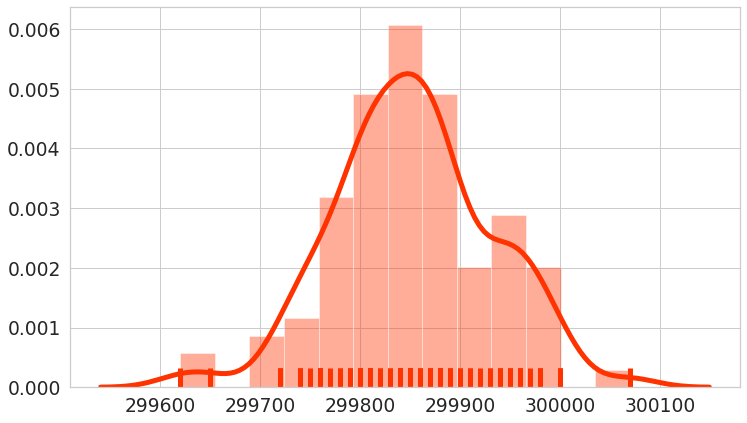

In [ ]:
speed = np.loadtxt('speed.txt')

sns.set(style='whitegrid', font_scale=1.7)
plt.figure(figsize=(12, 7))
sns.distplot(speed, rug=True, 
             color=red, kde_kws={'lw': 5}, rug_kws={'lw': 5});

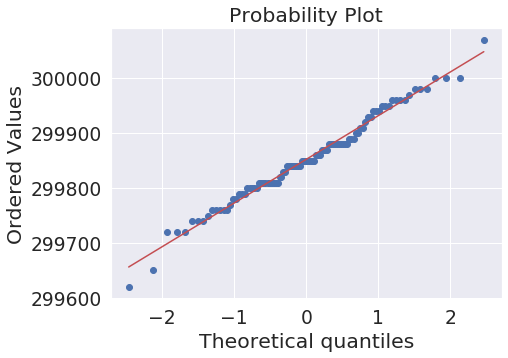

In [ ]:
sns.set(style='darkgrid', font_scale=1.7)
plt.figure(figsize=(7, 5))
sps.probplot(speed, plot=plt.subplot(111));

In [ ]:
pvalues = [sps.kstest(speed, sps.norm(*sps.norm.fit(speed)).cdf)[1],
           sps.shapiro(speed)[1],
           sps.jarque_bera(speed)[1]]

pvalues

[0.4813808419520875, 0.5140784382820129, 0.8628948044152577]

In [ ]:
multipletests(pvalues)

(array([False, False, False]),
 array([0.86050917, 0.86050917, 0.8628948 ]),
 0.016952427508441503,
 0.016666666666666666)

-----

Phystech@DataScience

https://mipt-stats.gitlab.io/